In [1]:
import matplotlib.pyplot as plt #plotting
import numpy as np #math
import pandas as pd #data
import seaborn as sns #plotting

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


In [3]:
# downloading dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# Pre-processing

In [5]:
# cleaning data
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
# Change 'Origin' column - categorical data
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [8]:
# converting into one-hot with pd.get_dummies
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [9]:
# splitting dataset into test and train
train_dataset = dataset.sample(frac=0.8, random_state=0) #80% in training, 20% in testing
test_dataset = dataset.drop(train_dataset.index)

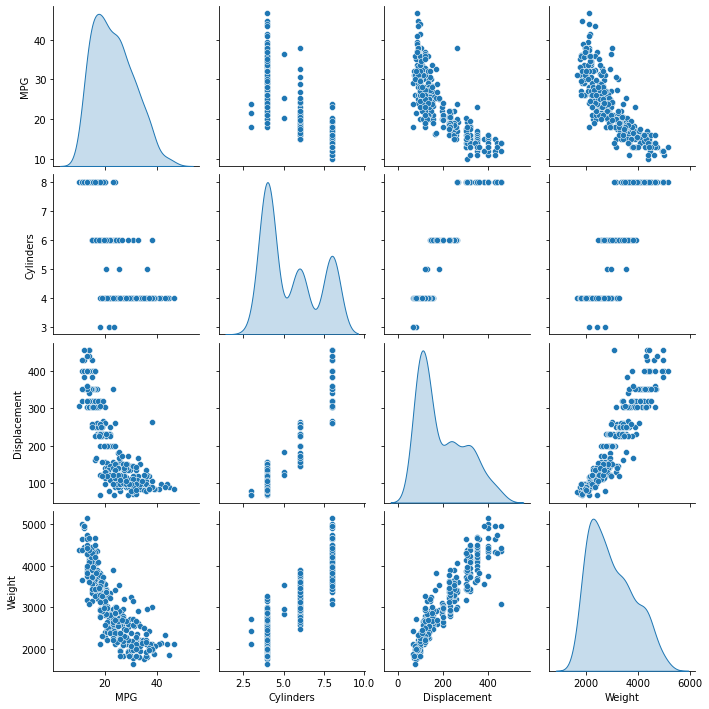

In [10]:
# graphing joint distribution of a few pairs of columns
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [12]:
# splitting features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# Normalization Layer

In [13]:
#creating the layer
normalizer = preprocessing.Normalization(axis=-1) 
#adapting it to the data - calculates mean and variance, then stores in layer
normalizer.adapt(np.array(train_features))

# printing means
print(normalizer.mean.numpy())

# comparing non-normalized to normalized version
first = np.array(train_features[:1])
with np.printoptions(precision=2, suppress=True):
  print('\nFirst example:', first)
  print('\nNormalized:', normalizer(first).numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# One-var Linear Regression

Single-variable regression to predict *MPG* from *Horsepower*
Model architecture: **keras.Sequential** (sequence of steps)
Two steps:
- Normalize input *Horsepower*
- Apply linear transformation (y=mx+b) using **layers.dense**

Number of inputs determined by **input_shape** or automatically when model is first run

In [14]:
# create Horsepower normalization layeer
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [15]:
# building sequential model - still untrained
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [16]:
# compiling model
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [17]:
%%time
# executing training
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

# visualize model training progress
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

CPU times: user 2.98 s, sys: 193 ms, total: 3.17 s
Wall time: 3.95 s


,loss,val_loss,epoch
95,3.805782,4.183211,95
96,3.804011,4.174087,96
97,3.806398,4.206038,97
98,3.802113,4.187930,98
99,3.805238,4.171010,99


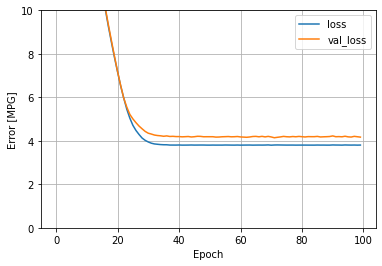

In [18]:
# plotting loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [19]:
# collect results on test set
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

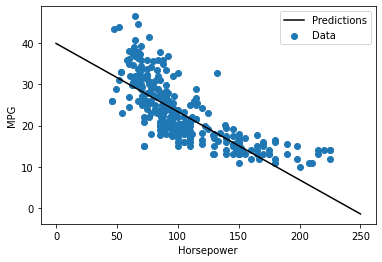

In [20]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

# plotting datapoints and regression line
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x,y)

# Multivariate Linear Regression

In [21]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])
# kernel (m in y=mx+b) has shape of (9,1) after call

array([[ 0.261],
       [ 0.964],
       [ 2.819],
       [-0.767],
       [-2.929],
       [ 0.786],
       [-3.131],
       [-1.755],
       [ 1.047],
       [-1.565]], dtype=float32)

In [22]:
# using same compile and fit functions as single variable
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [23]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.69 s, sys: 175 ms, total: 2.86 s
Wall time: 2.8 s


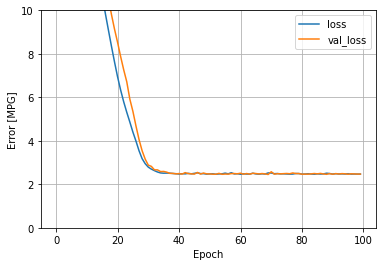

In [24]:
plot_loss(history)
# much lower training and validation error than single variable model

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# DNN Regression
Model is expanded to include "hidden" non-linear layers
- **Normalization** layer
- Two hidden, nonlinear **Dense** layers using *relu* nonlinearity
- Linear single-output layer

In [25]:
# Both 1-var and multivar DNN models will use the same training method

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### 1-var DNN

In [26]:
# 1-var Horsepower model
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [27]:
%%time
# training
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.11 s, sys: 233 ms, total: 3.34 s
Wall time: 3.57 s


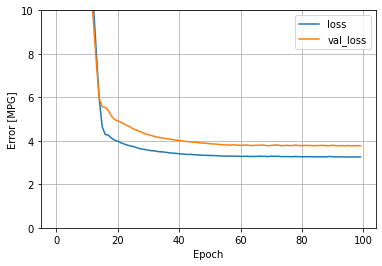

In [28]:
plot_loss(history)

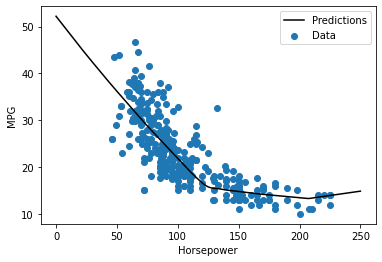

In [29]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)
plot_horsepower(x, y)
# nonlinear regression

# collecting results
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Full model

In [30]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [31]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.1 s, sys: 254 ms, total: 3.36 s
Wall time: 3.13 s


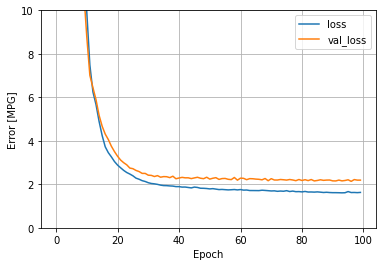

In [32]:
plot_loss(history)

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [34]:
# Performance comparison
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648033
linear_model,2.519105
dnn_horsepower_model,2.941885
dnn_model,1.711587


# Predictions

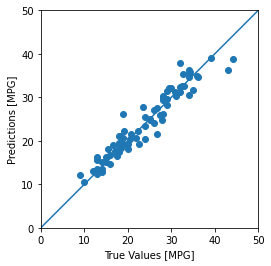

In [35]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

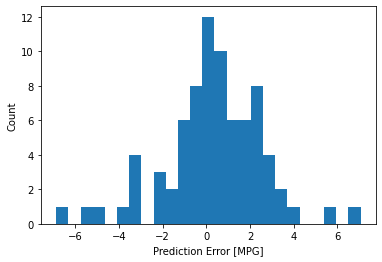

In [37]:
# error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [38]:
# saving model
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [41]:
# reloading model
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648033
linear_model,2.519105
dnn_horsepower_model,2.941885
dnn_model,1.711587
reloaded,1.711587



# Plotting the difference between USA/Germany/Japan

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa521784208>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa521a117b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa5217848d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fa521a11c88>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa521a11c50>,
 'means': []}

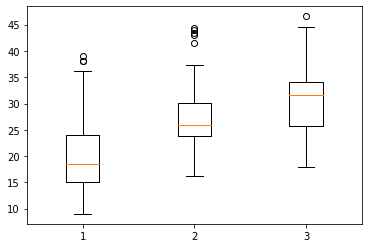

In [220]:
usa = dataset.loc[dataset['USA'] == 1]
euro = dataset.loc[dataset['Europe'] == 1]
jap = dataset.loc[dataset['Japan'] == 1]

#usa.boxplot(column=['MPG'])
#euro.boxplot(column=['MPG'])
#jap.boxplot(column=['MPG'])

plt.boxplot([usa['MPG'], euro['MPG'], jap['MPG']])

# Gradient Descent Linear Regression

In [174]:
def costFunction(theta, X, y):
    """
    Compute cost and gradients of logistic regression using theta
    input:
    theta - parameters
    X - m x n matrix of features
    y - n x 1 vector of 0/1
    
    output:
    cost - calculated value of J
    grad - m x 1 vector of partial derivative of J with respect to each feature
    """
    m = len(y)
    y = y.to_numpy()
    h = X.dot(theta)
    
    J = (h-y).T.dot(h-y)/(2*m)
    return J

def gradientDescent(X, y, theta, alpha, num_iters):
    """
    Update theta by num_iters times gradients with learning rate alpha
    
    input:
    X, y - dataset
    theta - parameters
    alpha - learning rate
    
    output:
    theta - updated parameters
    """
    cost_history = []
    m = len(y)
    for iter in range(num_iters):
        theta = theta - alpha / m * np.dot(X.T, X.dot(theta).flatten() - y).T
        cost_history.append(costFunction(theta, X, y))
    return theta, cost_history

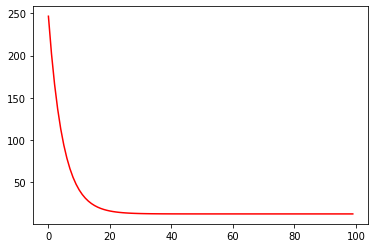

12.3689317539702


In [182]:
alpha = 0.1
num_iters = 100
horsepower_norm = (horsepower - horsepower.mean()) / horsepower.std()
horsepower_X = np.vstack((np.ones((len(horsepower_norm),)), horsepower_norm)).T
theta = np.zeros((2,1)).flatten()

params, costPlot = gradientDescent(horsepower_X, train_labels, theta, alpha, num_iters)

plt.plot(np.reshape(costPlot,(len(costPlot),1)),'r')
plt.show()
print(costPlot[-1])

In [190]:
def predict(theta, X):
    """
    Return boolean array of if hypothesis function >= 0.5
    
    input:
    theta - parameters
    X - data
    
    output:
    array of predictions
    """
    h = X.dot(theta)
    return h

predictions = predict(params, horsepower_X)

In [221]:
print(params)

[23.31  -5.899]


Graph gradient descent vs tensorflow model
